In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

SEED = 42

2023-10-24 15:09:11.073530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data:
Stock prices of NVDA from 26-10-2020 to 23-10-2023 (~3 year) 

In [2]:
df = pd.read_csv("NVDA.csv", index_col="Date", parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-26,134.270004,136.927505,130.384995,131.412506,131.089798,33689600
2020-10-27,133.059998,134.419998,131.914993,133.967499,133.638519,25052000
2020-10-28,131.979996,132.600006,126.089996,126.269997,125.959908,37652000
2020-10-29,128.384995,131.927505,127.500000,130.240005,129.920197,32008000
2020-10-30,128.500000,129.365005,123.000000,125.339996,125.032204,41682000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2020-10-26 to 2023-10-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       753 non-null    float64
 1   High       753 non-null    float64
 2   Low        753 non-null    float64
 3   Close      753 non-null    float64
 4   Adj Close  753 non-null    float64
 5   Volume     753 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,753.000000,753.000000,753.000000,753.000000,753.000000,7.530000e+02
mean,227.468894,231.883260,222.951534,227.598021,227.402718,4.522067e+07
std,99.326667,100.874986,97.487161,99.136808,99.183362,1.777842e+07
min,109.709999,117.349998,108.129997,112.269997,112.201363,9.788400e+06
25%,150.642502,153.350006,147.875000,150.820007,150.683029,3.227600e+07
50%,197.399994,200.987503,193.190002,197.979996,197.665634,4.374290e+07
75%,271.149994,274.989990,266.250000,271.190002,271.139587,5.516030e+07
max,502.160004,502.660004,489.579987,493.549988,493.509338,1.543911e+08


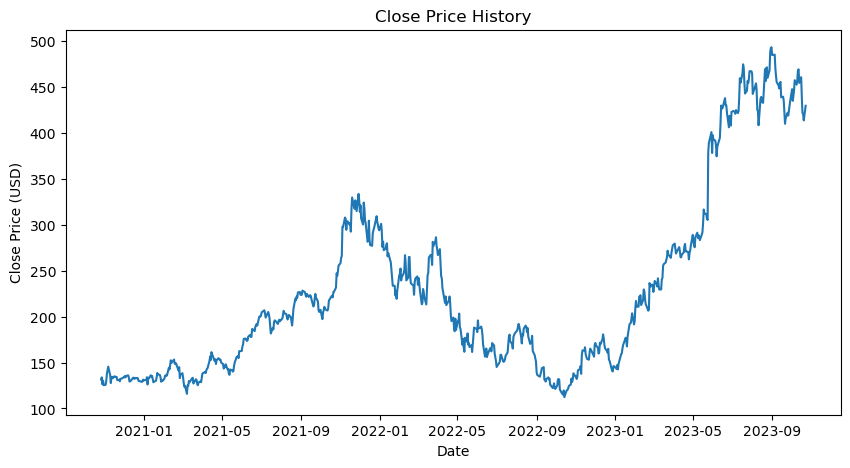

In [5]:
plt.figure(figsize=(10, 5))
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")

plt.plot(df["Close"])
plt.show()

# Preprocessing

In [6]:
# Extract close prices 
data = df.filter(["Close"]).values

# Number of previous days used for prediction
# Here I choose 60 days ~ 3 months
timesteps = 60

# Use first 90% of data for training and rest for testing
train_data_len = int(len(data) * 0.9)

In [7]:
def create_dataset(data, timesteps):
    """ 
    Create a dataset where X is an array of previous {timesteps} close prices and y is an array of current close price
    """
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i - timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [8]:
# Split train and test data
train_data = data[:train_data_len]
test_data = data[train_data_len - timesteps:]

# Normalize data for better performance
# Make sure to only fit the scaler on training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [9]:
X_train, y_train = create_dataset(train_data, timesteps)
X_test, _ = create_dataset(test_data, timesteps)

# Reshape data to fit LSTM model's input shape (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = data[train_data_len:]

# Modelling
LSTM is a type of RNN that remember information over long periods of time i.e. can process series information

They suited for predicting time series data, such as stock prices

I figured that for smaller data, simpler LSTM might be better, so my architeture is simple

In [10]:
def LSTM_model():
    """
    Create a LSTM model with 2 LSTM layers and 1 Dense layer
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(timesteps, 1)),

        LSTM(32, return_sequences=False),

        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [11]:
# Choose suitable batch size and number of epochs to balance between under and overfitting
lstm = LSTM_model()
lstm.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=1,
)

2023-10-24 15:09:14.440375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 15:09:14.458898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 15:09:14.459068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2023-10-24 15:09:15.140613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 15:09:15.141784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 15:09:15.142711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

617/617 [==============================] - 4s 3ms/step - loss: 0.0065
Epoch 2/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 3/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0017
Epoch 4/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0016
Epoch 5/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0014
Epoch 6/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 7/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 8/10
617/617 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 9/10
617/617 [==============================] - 2s 3ms/step - loss: 9.4915e-04
Epoch 10/10
617/617 [==============================] - 2s 3ms/step - loss: 9.2803e-04


In [12]:
y_pred = lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

2023-10-24 15:09:35.552353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 15:09:35.553448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 15:09:35.554366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step


17.21275897276722

This achieves a RMSE of ~17 on the test set

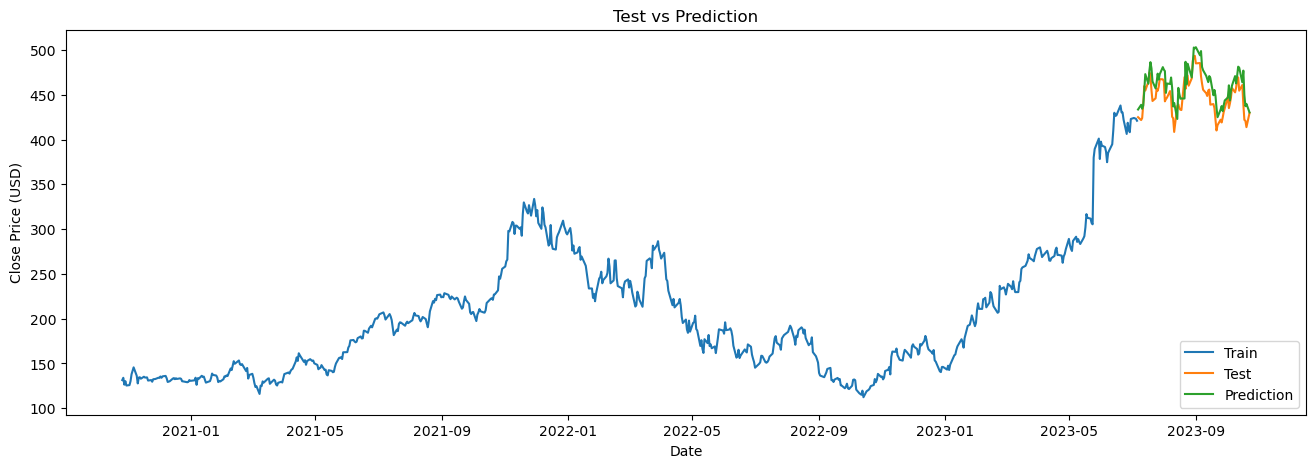

In [13]:
plt.figure(figsize=(16, 5))
plt.title("Test vs Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")

plt.plot(df["Close"][:train_data_len])
plt.plot(df["Close"][train_data_len:])
plt.plot(pd.DataFrame(y_pred, index=df["Close"][train_data_len:].index))
plt.legend(["Train", "Test", "Prediction"], loc="lower right")
plt.show()

# Inference
Now fit the model on the entire dataset and predict until 7 Nov

In [14]:
full_data = scaler.fit_transform(data)
X, y = create_dataset(full_data, timesteps)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

lstm = LSTM_model()
lstm.fit(
    X,
    y,
    epochs=10,
    batch_size=1,
)

Epoch 1/10


2023-10-24 15:09:36.173502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 15:09:36.174532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 15:09:36.175328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-24 15:09:36.502050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 15:09:36.503173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 15:09:36.504096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

693/693 [==============================] - 4s 3ms/step - loss: 0.0066
Epoch 2/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0024
Epoch 3/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0021
Epoch 4/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0015
Epoch 5/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0015
Epoch 6/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 7/10
693/693 [==============================] - 2s 3ms/step - loss: 0.0010
Epoch 8/10
693/693 [==============================] - 2s 3ms/step - loss: 9.5187e-04
Epoch 9/10
693/693 [==============================] - 2s 3ms/step - loss: 8.8512e-04
Epoch 10/10
693/693 [==============================] - 2s 3ms/step - loss: 8.5558e-04


Method: predict the next day, then use that prediction to predict the next day, and so on

prediction(t+1) = model(data(t), data(t - 1), ..., data(t - 60))

prediction(t+2) = model(prediction(t+1), data(t), data(t - 1), ... data(t - 59))

In [15]:
start_date = df.index[-1] + pd.Timedelta(days=1)
end_date = pd.to_datetime("2023-11-7")

days_to_predict = pd.date_range(start_date, end_date, freq="B").shape[0]

cur_data = full_data.copy()
for _ in range(days_to_predict):
    last_data = cur_data[-timesteps:]
    last_data = np.reshape(last_data, (1, timesteps, 1))

    prediction = lstm.predict(last_data)
    cur_data = np.append(cur_data, prediction, axis=0)

prediction = scaler.inverse_transform(cur_data[-days_to_predict:])

2023-10-24 15:09:59.212734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-24 15:09:59.213814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-24 15:09:59.214686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 13ms/step


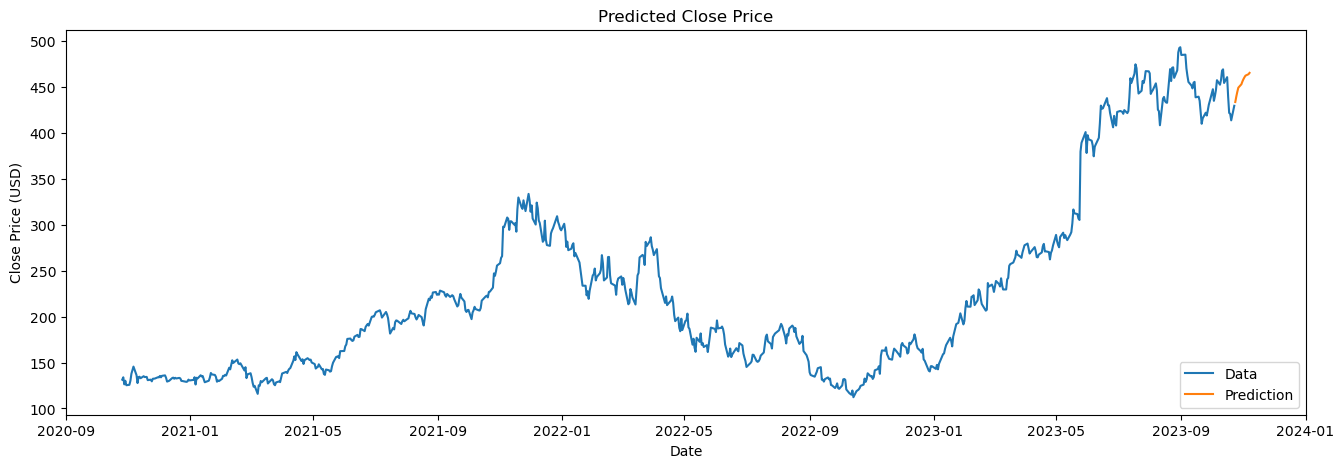

In [16]:
plt.figure(figsize=(16, 5))
plt.title("Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)") 

plt.plot(df["Close"])
plt.plot(pd.DataFrame(prediction, index=pd.date_range(start_date, end_date, freq="B")))
plt.legend(["Data", "Prediction"], loc="lower right")
plt.show()

In [17]:
days_to_submit = 10
submission = pd.DataFrame({
    "index": range(days_to_submit),
    "Close": prediction[-days_to_submit:, 0],
})
submission.to_csv("submission1.csv", index=False)
submission

,index,Close
0,0,439.807110
1,1,445.034126
2,2,449.486433
3,3,453.185872
4,4,456.221437
5,5,458.716440
6,6,460.798874
7,7,462.583097
8,8,464.160877
9,9,465.599345


In [18]:
!kaggle competitions submit -c fintech-project-1 -f submission1.csv -m "Message"

100%|████████████████████████████████████████████| 219/219 [00:00<00:00, 531B/s]
Successfully submitted to Training Wing Project 1: Stock Price Prediction